In [ ]:
import pandas as pd 
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import time
from gensim.models import Word2Vec
from tqdm import tqdm

tqdm.pandas()

In [ ]:
!rm kaggle.json
!pip install -U -q kaggle --force
from google.colab import files
f=files.upload()

rm: cannot remove 'kaggle.json': No such file or directory
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
df = pd.read_csv("/content/drive/My Drive/NNFL/NLP/Lab4/train.csv")
tdf =  pd.read_csv("/content/drive/My Drive/NNFL/NLP/Lab4/test.csv")


In [ ]:
print(df.shape)
print(tdf.shape)

(16000, 4)
(4700, 3)


In [ ]:
pd.set_option('display.max_colwidth',-1)
df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,ID,Sentence1,Sentence2,Class
0,0,"But instead of returning to heaven , Annie decided to join Chris in hell forever .","But instead of returning to Heaven , Chris chooses to join Annie forever in Hell .",0
1,1,"In 2016 , Bacardi announced new branding and plans to sell their version of Havana Club nationally , which will be burned in Florida and bottled in Puerto Rico .","In 2016 , Bacardi announced new branding and plans to sell their version of Havana Club nationally , which will be distilled in Puerto Rico and bottled in Florida .",0
2,2,"Kweku Baako Jnr had four children . One of them , Baako is a journalist and editor of the `` New Crusading Guide '' newspaper .","Baako had four children , one of whom was Kweku Baako Jnr , a journalist and editor of the newspaper `` New Crusading Guide '' .",0
3,3,"As with the Navy , the Army has a single-track system , where officers from other Navy communities transfer over to Foreign Area Officer permanently .","Like the army , the Navy has a single-track system , where officers from other Navy communities permanently transfer to Foreign Area Officer .",0
4,4,Sissi units have fewer crew served weapons and more sniper rifles than regular infantry .,Sissi units have more weapons served by the crew and fewer sniper rifles than regular infantry .,0
5,5,"However , the United States later forced other nations and American companies to restrict trade with Cuba with foreign subsidiaries .","However , the United States later pressured other nations and foreign companies with American subsidiaries to restrict trade with Cuba .",0
6,6,Deutsche Bahn opened a new underground tunnel to the new railway station Filderstadt on 29 September 2001 .,"On 29 September 2001 , Deutsche Bahn opened a new tunnel to the new Filderstadt U-Bahn ( underground ) station .",0
7,7,"Some Hebrew and Aramaic abbreviations may not be included here ; more may be found in the List of Hebrew abbreviations and the List of Aramaic abbreviations , respectively .","Some Hebrew and Aramaic abbreviations may not be included here , and others may be found in the list of Hebrew abbreviations or in the list of Aramaic abbreviations .",1
8,8,`` Yesteryear '' is the first episode of the second season of animated American science - fiction - television series .,`` Yesteryear '' is the second episode of the first season of the animated American Science - Fiction - TV series .,0
9,9,Principal photography took place in additional installments between July 2016 and October 2016 with small pick-up days in December 2016 and January 2017 .,Principal - Photography took place between July 2016 and October 2016 in small installments with additional collection dates in December 2016 and January 2017 .,0


In [ ]:
num_words = 33059

In [ ]:
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(np.concatenate([df['Sentence1'].values,df['Sentence2'].values , tdf['Sentence1'].values , tdf['Sentence2'].values]))
X = tokenizer.texts_to_sequences(df['Sentence1'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_length_of_text = 100
X = pad_sequences(X, maxlen=max_length_of_text)

Y = tokenizer.texts_to_sequences(df['Sentence2'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
Y = pad_sequences(Y, maxlen=max_length_of_text)

t_X = tokenizer.texts_to_sequences(tdf['Sentence1'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
t_X = pad_sequences(t_X, maxlen=max_length_of_text)

t_Y = tokenizer.texts_to_sequences(tdf['Sentence2'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
t_Y = pad_sequences(t_Y, maxlen=max_length_of_text)

Found 33059 unique tokens.
Found 33059 unique tokens.
Found 33059 unique tokens.
Found 33059 unique tokens.


In [ ]:
x = (' ').join([word for word in ['urvil','jivani','bits'] if len(word) > 1])
print(x)

urvil jivani bits


In [ ]:
def preprocessing(titles_array):
    
    """
    Take in an array of titles, and return the processed titles.
    
    (e.g. input: 'i am a boy', output - 'am boy')  -> since I remove those words with length 1
    
    Feel free to change the preprocessing steps and see how it affects the modelling results!
    """
    
    processed_array = []
    
    for title in tqdm(titles_array):
        print(title)
        # remove other non-alphabets symbols with space (i.e. keep only alphabets and whitespaces).
        processed = re.sub('[^a-zA-Z0-9 ]', '', title)
        
        words = processed.lower().split()
        x = [word+' ' for word in words if len(word) > 1]
        print(x)
        # keep words that have length of more than 1 (e.g. gb, bb), remove those with length 1.
        processed_array.append(x)
    
    return processed_array
df['processed_Sentence1'] = preprocessing(df['Sentence1'])

NameError: ignored

In [ ]:
df['processed_Sentence1'] = preprocessing(df['Sentence1'])
df['processed_Sentence2'] = preprocessing(df['Sentence2'])
tdf['processed_Sentence1'] = preprocessing(tdf['Sentence1'])
tdf['processed_Sentence2'] = preprocessing(tdf['Sentence2'])


100%|██████████| 4700/4700 [00:00<00:00, 154637.82it/s]


In [ ]:
df['processed_Sentence1'][1]

'In2016BacardiannouncednewbrandingandplanstoselltheirversionofHavanaClubnationallywhichwillbeburnedinFloridaandbottledinPuertoRico'

In [ ]:
sentences = pd.concat([df['processed_Sentence1'],df['processed_Sentence2'],tdf['processed_Sentence1'],tdf['processed_Sentence2']],axis=0)
train_sentences = list(sentences.progress_apply(str.split).values)

100%|██████████| 41400/41400 [00:00<00:00, 236427.19it/s]


In [ ]:
start_time = time.time()

model = Word2Vec(sentences=train_sentences, 
                 sg=1, 
                 size=100,  
                 workers=4)

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 0.00 mins


In [ ]:
len(model.wv.vocab.keys())

6

NameError: ignored

In [ ]:
!wget https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz

--2020-04-25 16:34:48--  https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.200d.txt.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-04-25 16:34:50 ERROR 404: Not Found.



In [ ]:
! gunzip glove.6B.50d.txt.gz

In [ ]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in pretrained word vector model.' % len(embeddings_index))
print('Dimensions of the vector space : ', len(embeddings_index['the']))

Found 400000 word vectors in pretrained word vector model.
Dimensions of the vector space :  50


In [ ]:
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer1 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length_of_text,
                            trainable=False)

embedding_layer2 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length_of_text,
                            trainable=False)

In [ ]:
label = df["Class"]

In [ ]:
embed_dim = EMBEDDING_DIM #Change to observe effects
lstm_out = 64 #Change to observe effects
batch_size = 128

inputs1 = Input((max_length_of_text,))
inputs2 = Input((max_length_of_text,))
y1=embedding_layer1(inputs1)
y2=embedding_layer2(inputs2)

print(y1.shape)
# y1=Conv1D(128,5,activation='relu')(y1)
# print(y1.shape)
# y1=MaxPooling1D(5)(y1)
# print(y1.shape)
y1=Conv1D(64,5,activation='relu')(y1)
print(y1.shape)
y1=MaxPooling1D(4)(y1)
print(y1.shape)
y1=Conv1D(64,5,activation='relu')(y1)
print(y1.shape)
y1=MaxPooling1D(4)(y1)
print(y1.shape)
y1=Conv1D(64,5,activation='relu')(y1)
print(y1.shape)
# y2=Conv1D(128,5,activation='relu')(y2)
# y2=MaxPooling1D(5)(y2)
y2=Conv1D(64,5,activation='relu')(y2)
y2=MaxPooling1D(4)(y2)
y2=Conv1D(64,5,activation='relu')(y2)
y2=MaxPooling1D(4)(y2)
y2=Conv1D(64,5,activation='relu')(y2)

y1 = Flatten()(y1)
y2 = Flatten()(y2)
x_y = Subtract()([y1,y2])
# x_y = Bidirectional(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(x_y)
x_y=Dense(64,activation='relu')(x_y)
x_y=Dropout(0.5)(x_y)
x_y=Dense(32,activation='relu')(x_y)
x_y=Dense(1,activation='sigmoid')(x_y)
model = Model([inputs1,inputs2], x_y)
print(model.summary())

NameError: ignored

In [ ]:
from keras import optimizers
opti = optimizers.Adam(lr = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer=opti,metrics = ['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# earlystop = EarlyStopping(monitor = 'val_acc', patience=4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2 , verbose=1, factor=0.5, min_lr=0.00001)
mc = ModelCheckpoint('/content/drive/My Drive/NNFL/NLP/Lab4/day2_model4_campusID.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
history = model.fit([X,Y],label,batch_size=batch_size,epochs = 30,validation_split=.2,
                               callbacks = [learning_rate_reduction, mc])

Train on 12800 samples, validate on 3200 samples
Epoch 1/30
12800/12800 [==============================] - 9s 714us/step - loss: 0.6931 - accuracy: 0.5459 - val_loss: 0.6866 - val_accuracy: 0.5541

Epoch 00001: val_loss improved from inf to 0.68664, saving model to /content/drive/My Drive/NNFL/NLP/Lab4/day2_model4_campusID.h5
Epoch 2/30
12800/12800 [==============================] - 9s 675us/step - loss: 0.6879 - accuracy: 0.5517 - val_loss: 0.6872 - val_accuracy: 0.5550

Epoch 00002: val_loss did not improve from 0.68664
Epoch 3/30
12800/12800 [==============================] - 9s 678us/step - loss: 0.6850 - accuracy: 0.5619 - val_loss: 0.6871 - val_accuracy: 0.5584

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00003: val_loss did not improve from 0.68664
Epoch 4/30
12800/12800 [==============================] - 9s 680us/step - loss: 0.6783 - accuracy: 0.5795 - val_loss: 0.6838 - val_accuracy: 0.5672

Epoch 00004: val_loss improved from 0.68664

KeyboardInterrupt: ignored

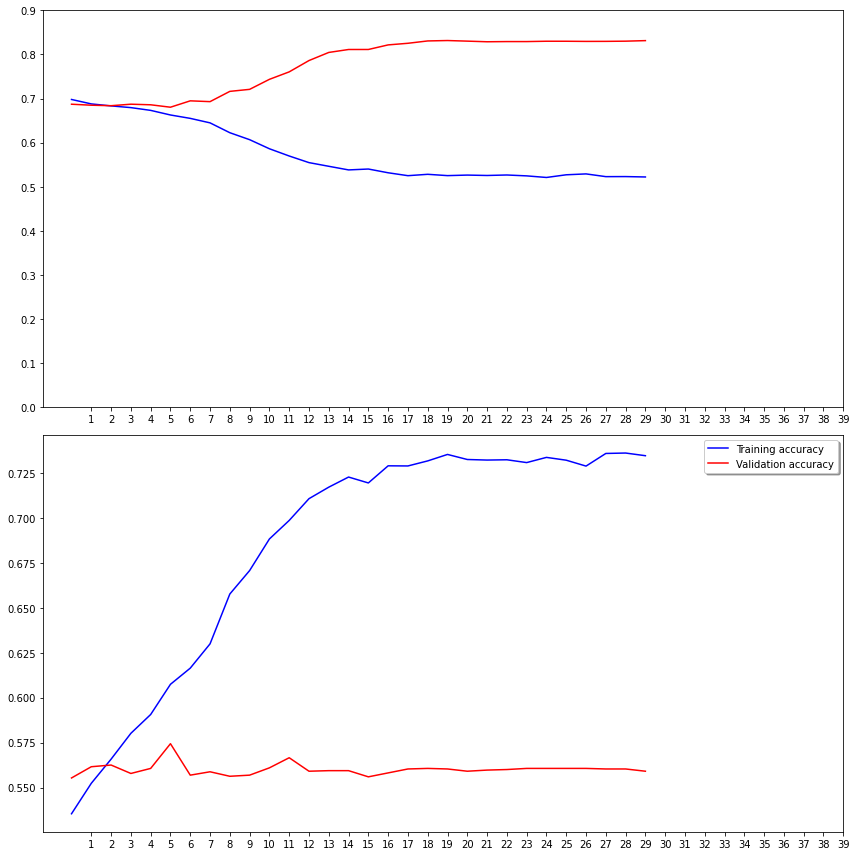

In [ ]:
import matplotlib.pyplot as plt 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 40, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 40, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()